In [7]:
# Import packages:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from fixdata import fixdata

# Set default plotting parameters:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams[ 'font.sans-serif'  ] = 'Calibri'
mpl.rcParams[ 'font.size'        ] = 10
mpl.rcParams[ 'mathtext.default' ] = 'regular'          
mpl.rcParams[ 'xtick.direction'  ] = 'out'
mpl.rcParams[ 'ytick.direction'  ] = 'out'       
mpl.rcParams[ 'lines.linewidth'  ] = 1.0     

dt = 1./24. # define sampling frequency in days

# Specify dataset name and Earth tide component names and parameters:
name = str(int(np.loadtxt('Data/name.txt')))
tide = ['O$_1$   ', 'P$_1$   ', 'S$_1$   ', 'K$_1$   ', '$\phi_1$',
        '$\psi_1$', 'N$_2$   ', 'M$_2$   ', 'S$_2$   ', 'K$_2$   ']
period = [  25.819,   24.066,   24.000,   23.934,   23.869, 
            23.804,   12.658,   12.421,   12.000,   11.967]
p     = np.array(period) 
NP    = len(p) # number of Earth tide components
omega = 2.*np.pi/p # angular frequency values
np.savetxt('Data/tide.dat', tide, fmt='%s')
np.savetxt('Data/p.dat', p)
np.savetxt('Data/omega.dat', omega)

# Import vented groundwater pressure logger data:
data = np.loadtxt('Data/titree1.txt', delimiter='\t')
#data = np.loadtxt('Data/'+name+'.txt', delimiter='\t')
k  = range(30-1, len(data))
t1 = data[k,0] # time 
w1 = data[k,1] # groundwater pressure
T1 = data[k,2] # temperature
w1 = fixdata(w1, 0.3) # remove fluctuations > 0.3 cm
np.savetxt('Data/t1.dat',  t1)
np.savetxt('Data/w1.dat',  w1)
np.savetxt('Data/T1b.dat', T1)

# Import barometric logger data:
data = np.loadtxt('Data/titree2.txt', delimiter='\t') 
k  = range(20-1, len(data))
t2 = data[k,0] # time 
T2 = data[k,1] # temperature
h2 = data[k,2] # gauge pressure
bp = data[k,3] # barometric pressure 
bp = fixdata(bp, 1.) # remove fluctuations > 1.0 cm
w2 = h2-bp # convert to gauge pressure (by subtracting barometric pressure)
w2 = fixdata(w2, 1.) # remove fluctuations > 1.0 cm 
bp = bp-1033.227 # subtract mean barometric pressure
np.savetxt('Data/t2.dat',  t2)
np.savetxt('Data/T2b.dat', T2)
np.savetxt('Data/h2.dat',  h2)
np.savetxt('Data/w2.dat',  w2)
np.savetxt('Data/bp.dat',  bp)

# Resample vented groundwater and barometric pressure data to hourly frequency:
t = np.arange(t2[0], t2[-1]+dt, dt) # time
y = np.interp(t, t1, w1) # vented groundwater pressure
x = np.interp(t, t2, bp) # barometric pressure
dx = np.diff(x)/dt # hourly temporal derivative of barometric pressure
dy = np.diff(y)/dt # hourly temporal derivative of vented groundwater pressure
np.savetxt('Data/t.dat',  t)
np.savetxt('Data/x.vec',  x)
np.savetxt('Data/y.vec',  y)
np.savetxt('Data/dx.dat', dx)
np.savetxt('Data/dy.dat', dy)

# Define number of lags to test:
n   = len(dx)
nn  = range(n) 
lag = range(240+1) # lags, in hour units
np.savetxt('Data/nn.dat',  nn)
np.savetxt('Data/lag.dat', lag)

# Formulate v sub-matrix: (?)
nm = len(lag)
v = np.zeros([n, nm])
for i in range(nm):
    j = lag[i]
    k = np.arange(n-j)
    v[j+k, i] = dx[k] 
np.savetxt('Data/v.mat', v)

# Formulate u1 and u2 sub-matrices: (?)
u1 = np.zeros([n, NP])
u2 = u1.copy()
for i in range(NP):
    u1[:,i] = np.cos(omega[i]*t[nn])
    u2[:,i] = np.sin(omega[i]*t[nn])

# Formulate X matrix by hstacking each of v, u1 and u2: (?)
X = np.hstack([v, u1, u2])
np.savetxt('Data/X.mat', X)

# Formulate Z matrix by pre-appending a column of 1's: (?)
Z = np.hstack([np.ones([n,1]), X])
np.savetxt('Data/Z.mat', Z)

# Calculate c vector by solving the linear system of equations Z*dy=c:
c  = np.linalg.lstsq(Z, dy, rcond=None)[0]
nc = len(c)
np.savetxt('Data/c.dat', c)

# Calculate observation and parameter standard errors: (?)
py = y-dt*np.concatenate([[0.], np.cumsum(np.dot(X, c[1:nc]))])
oerror = np.std(dy)
perror = np.std(dy-np.dot(Z,c))
np.savetxt('Data/py.dat', py)

trend = c[1] # trend term
brf   = c[1+np.arange(nm)] # instantaneous barometric response function
crf   = np.abs(np.cumsum(brf)) # cumulative barometric response function
k     = np.concatenate([np.atleast_1d([nm+1]), np.arange(NP)])
trf   = [a+1j*b for a,b in zip(c[k], c[NP+k])] # complex barometric response function
mag   = np.abs(trf) # amplitude values of trf
phase = np.angle(trf) # phase values of trf 

# Convert time data from float values to datetime values:
t = [datetime.utcfromtimestamp(i) for i in ((np.array(t)-25569.)*86400.)]

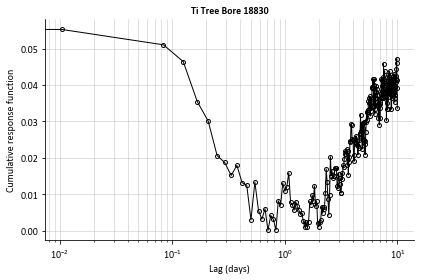

In [8]:
# Plot cumulative response function values versus lag size, in hours
%matplotlib inline
f,s = plt.subplots()
lag[1] = 0.25
s.set_title('Ti Tree Bore '+name, fontsize=10, fontweight='bold')
plt.semilogx(np.array(lag)/24., crf, 'ko-', ms=4, mec='k', mfc='none', mew=1.)
s.set_xlabel('Lag (days)')
s.set_ylabel('Cumulative response function')
#s.set_xlim(1e-2, 1)
#s.set_ylim(0.00, 0.07)
for i in ['top', 'right']:
    s.spines[i].set_visible(False)
s.grid(which='major', axis='both', c=(194./255., 194./255., 194./255.), ls='-', lw=0.5)                            
s.grid(which='minor', axis='x', c=(194./255., 194./255., 194./255.), ls='-', lw=0.5)                            
plt.tight_layout()

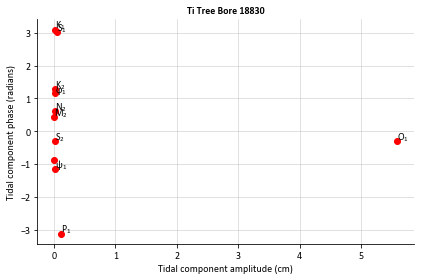

In [9]:
# Plot Nyquist plot (i.e. amplitude versus phase) of values derived from complex barometric response function:  
%matplotlib inline
f,s = plt.subplots()
s.set_title('Ti Tree Bore '+name, fontsize=10, fontweight='bold')
s.plot(mag, phase, 'ro')
s.set_xlabel('Tidal component amplitude (cm)')
s.set_ylabel('Tidal component phase (radians)')
for i in range(NP):
    s.text(mag[i]+5e-4, phase[i]+5e-2, tide[i])
#s.set_xlim(0.00, 0.05)
#s.set_ylim(-4., 3.)
for i in ['top', 'right']:
    s.spines[i].set_visible(False)
s.grid(which='major', axis='both', c=(194./255., 194./255., 194./255.), ls='-', lw=0.5)                            
plt.tight_layout()

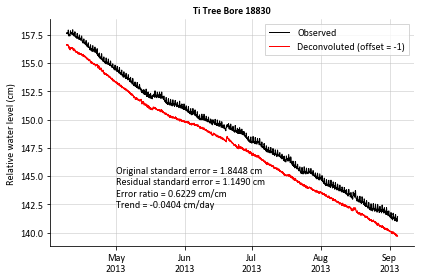

In [13]:
# Plot observed and deconvoluted pressure values versus time: 
%matplotlib inline
f,s = plt.subplots()
s.set_title('Ti Tree Bore '+name, fontsize=10, fontweight='bold')
s.plot(t, y,     'k-', label='Observed')
s.plot(t, py-1., 'r-', label='Deconvoluted (offset = -1)')
s.set_ylabel('Relative water level (cm)')
s.legend(fancybox=False)
to = datetime(2013, 5, 1)
yo = 145.25 
s.text(to, yo,   'Original standard error = '+str('%.4f'% oerror)+' cm')
s.text(to, yo-1, 'Residual standard error = '+str('%.4f'% perror)+' cm')
s.text(to, yo-2, 'Error ratio = '+str('%.4f'% (perror/oerror))+' cm/cm')
s.text(to, yo-3, 'Trend = '+str('%.4f'% trend)+' cm/day')
s.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
#s.set_xlim(datetime(2013, 4, 5), datetime(2013, 9, 10))
#s.set_ylim(140., 158.)
for i in ['top', 'right']:
    s.spines[i].set_visible(False)
s.grid(which='major', axis='both', c=(194./255., 194./255., 194./255.), ls='-', lw=0.5)                            
plt.tight_layout()